In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

os.chdir(Path(os.getcwd()).parent)
from assistive_arm.utils.data_preprocessing import prepare_opencap_markers
from assistive_arm.utils.optimum_length_utils import compute_torque_profiles, get_jacobian, get_rotation_matrix
from assistive_arm.utils.plotting import create_torque_plot

## Read data

### Marker data

In [4]:
subject = "subject_1"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject testing/Subject data/") / subject
trial = subject_data / "trial_2"

project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")
control_solutions = project_moco_data / "control_solutions"

# Set directories
opencap_markers = pd.read_csv(trial / "opencap_tracker.trc", delimiter="\t", skiprows=3).tail(-1)
filtered_markers = prepare_opencap_markers(opencap_markers)

# Read solution and yaml config
solution_path = control_solutions / "opencap_simple_assistance_false_2023-09-22_17-13.sto"
control_solution = pd.read_csv(solution_path, delimiter="\t", skiprows=18)
config_path = control_solutions / f"{solution_path.stem}.yaml"

try:
    with open(config_path, "r") as f:
        config_file = yaml.load(f, Loader=yaml.FullLoader)
except FileNotFoundError:
    print(f"No config file found at {config_path}")


No config file found at /Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/control_solutions/opencap_simple_assistance_false_2023-09-22_17-13.yaml


### Get pelvis marker and set it as human anchoring position

In [5]:
pelvis_x = (filtered_markers["r.PSIS_study"].X + filtered_markers["L.PSIS_study"].X)/2 
pelvis_y = (filtered_markers["r.PSIS_study"].Y + filtered_markers["L.PSIS_study"].Y)/2 
pelvis_z = (filtered_markers["r.PSIS_study"].Z + filtered_markers["L.PSIS_study"].Z)/2 

pelvis_marker = pd.DataFrame({"Time": filtered_markers.Time.t, "X": pelvis_x, "Y": pelvis_y, "Z": pelvis_z})
pelvis_marker = pelvis_marker[(pelvis_marker.Time >= 1.8) & (pelvis_marker.Time <= 3.2)].reset_index(drop=True)
pelvis_marker.set_index("Time", inplace=True)
new_index = pd.Index(np.arange(pelvis_marker.index.min(), pelvis_marker.index.max() + 0.025, step=0.025), name="Time")
pelvis_marker_aligned = pelvis_marker.reindex(new_index, method="nearest")


### Read assistive force profile

In [6]:
assistive_force = control_solution[["time", "/forceset/reserve_jointset_ground_pelvis_pelvis_tx", "/forceset/reserve_jointset_ground_pelvis_pelvis_ty"]]
assistive_force.set_index("time", inplace=True)
assistive_force.columns = ["X", "Y"]
assistive_force.insert(2, "Z", 0)
assistive_force *= 100
assistive_force *= 2/3

## Calculate optimal link length ratio

### Get distance vector from pelvis to anchor point

In [7]:
chair_position = np.array([-0.6, 0.5, -0.075])
pelvis_to_chair = chair_position - pelvis_marker_aligned

print(f"Anchoring point on bench: {pelvis_to_chair.X.iloc[0]:.3f}m away from pelvis")


Anchoring point on bench: -0.247m away from pelvis


### Calculate optimal length

In [8]:
min_necessary_length = np.linalg.norm(pelvis_to_chair, axis=1).max()

print("Minimum total length: ", min_necessary_length)

resolution = 30

link_lengths_1 = np.linspace(0.1, 1, resolution)
link_lengths_2 = np.linspace(0.1, 1, resolution)
link_lengths_1 = link_lengths_1[link_lengths_1 < min_necessary_length]
link_lengths_2 = link_lengths_2[link_lengths_2 < min_necessary_length]

# Set joint angle limits (degrees)
theta_1_lims = np.deg2rad([0, 180])
theta_2_lims = np.deg2rad([-145, 145])

results = []

for l1 in link_lengths_1:
    for l2 in link_lengths_2:
        if l1 + l2 < min_necessary_length:
            continue
        
        torques, joint_angles, jacobians = compute_torque_profiles(l1, l2, F=assistive_force, position=pelvis_to_chair)

        # Don't include invalid values
        if np.any(np.isnan(torques)) or np.any(np.isnan(joint_angles)):
            continue

        result = {
            'l1': l1,
            'l2': l2,
            'tau_1': torques[:, 0],
            'tau_2': torques[:, 1],
            'theta_1': joint_angles.theta_1,
            'theta_2': joint_angles.theta_2,
            'jacobians': jacobians,
        }
        results.append(result)

Minimum total length:  0.8402363059070971


### Filter out infeasible torque profiles

In [9]:
def check_theta(series, theta_lims):
    return series.apply(lambda x: theta_lims[0] <= x <= theta_lims[1]).all()

feasible_profiles = pd.DataFrame(results)
feasible_profiles.dropna(inplace=True)

# Filter out solutions that are outside of the joint angle limits
feasible_profiles = feasible_profiles[feasible_profiles["theta_1"].apply(check_theta, theta_lims=theta_2_lims) & feasible_profiles["theta_2"].apply(check_theta, theta_lims=theta_2_lims)]

### Get ideal torque combination

In [101]:
# Get link lengths that minimizes the peak torque for both motors
torques = feasible_profiles[["tau_1", "tau_2"]].map(lambda x: np.abs(x).max())
min_overall_torque = np.linalg.norm(torques, axis=1)
min_torque_loc = min_overall_torque.argmin()

l1, l2, tau_1, tau_2, theta_1, theta_2, jacobians = feasible_profiles.iloc[min_torque_loc]

optimal_profile = pd.DataFrame({'theta_1': theta_1, 'theta_2': theta_2, 'tau_1': tau_1, 'tau_2': tau_2})

control_solutions

PosixPath('/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/control_solutions')

### Calculate necessary bar length based on offset from rotational axis and link inserts

In [13]:
bar_1 = l1 - 0.103 # Constants based on CAD model (dist from bar to rot axis)
bar_2 = l2 - 0.081125
print(f"Bar 1: {bar_1:.3f} m")
print(f"Bar 2: {bar_2:.3f} m")

Bar 1: 0.338 m
Bar 2: 0.329 m


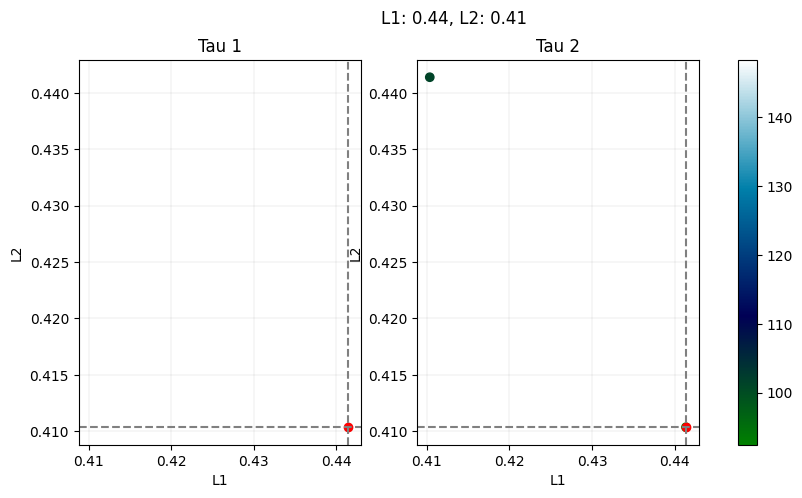

In [14]:
create_torque_plot(torques=torques, feasible_profiles=feasible_profiles, l1=l1, l2=l2)

### Calculate End Effector and Elbow trajecotries based on optimal link length

In [120]:
rotate_90 = get_rotation_matrix(90)

P_EE = np.array([l1*np.cos(theta_1) + l2*np.cos(theta_1 + theta_2), l1*np.sin(theta_1) + l2*np.sin(theta_1 + theta_2), theta_1 + theta_2])
P_L1 = np.array([l1*np.cos(theta_1), l1*np.sin(theta_1), np.zeros(theta_1.shape)])

optimal_profile['X'] = P_EE[0, :]
optimal_profile['Y'] = P_EE[1, :]
optimal_profile['theta_1_2'] = P_EE[2, :]

profile_path = Path(trial / "optimal_profile.csv")
optimal_profile.to_csv(profile_path)

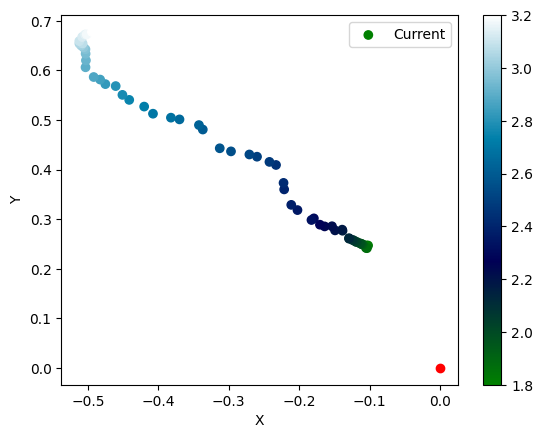

In [16]:
plt.scatter(P_EE[0], P_EE[1], c=pelvis_to_chair.index, cmap="ocean", label="Current")
plt.colorbar()
plt.plot(0, 0, "o", c="r")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

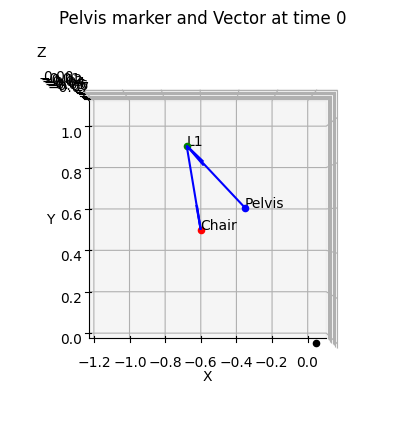

In [17]:
rotate_90 = get_rotation_matrix(90)

timestep = 0
plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.view_init(azim=-90, elev=90)

pelvis_pos = pelvis_marker_aligned.iloc[timestep]
pelvis_chair = pelvis_to_chair.iloc[timestep].T

l1_vector = rotate_90 @ P_L1.T[timestep, :]
l1_origin = pelvis_pos
l1_pos = pelvis_pos + l1_vector

l2_pos = rotate_90 @ P_EE.T[timestep, :]
l2_origin = l1_pos
l2_vector = l2_pos - l1_vector

ee_pos = pelvis_pos + l2_pos

ax.scatter(*pelvis_pos, color="b")
ax.text(*pelvis_pos, "Pelvis")

ax.scatter(*l1_pos, color="g")
ax.text(*l1_pos, "L1")

ax.scatter(*chair_position, color="r")
ax.text(*chair_position, "Chair")

origin = [0, 0, 0]
ax.scatter(*origin, color="k")

# ax.quiver(*pelvis_pos, *pelvis_chair, color="b")
ax.quiver(*l1_origin, *l1_vector, color="b")
ax.quiver(*l2_origin, *l2_vector, color="b")
ax.set_xlim([-1.2, pelvis_marker_aligned.X.max()])
ax.set_ylim([0, 1.1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pelvis marker and Vector at time {}'.format(timestep))

plt.show()

In [18]:
time_vector = (assistive_force.index - assistive_force.index.min())/(assistive_force.index.max() - assistive_force.index.min())* 100


torque_profile = pd.DataFrame({"tau_1": tau_1, 'tau_2': tau_2}, index=time_vector)

theta_1_dot = np.gradient(theta_1) / assistive_force.index.diff()
theta_2_dot = np.gradient(theta_2) / assistive_force.index.diff()

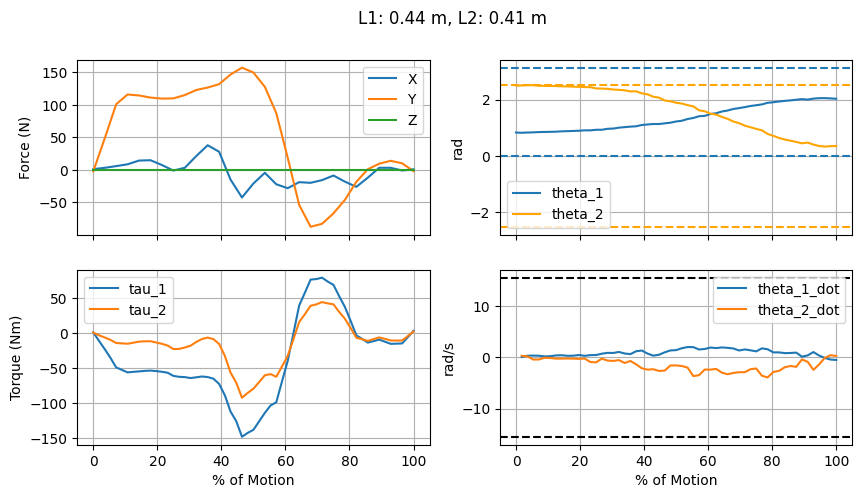

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True)
fig.suptitle(f"L1: {float(l1):.2f} m, L2: {float(l2):.2f} m")
axs[0, 0].plot(time_vector, assistive_force)
axs[0, 0].set_ylabel("Force (N)")
axs[0, 0].legend(["X", "Y", "Z"])
axs[0, 0].grid()

axs[1, 0].plot(time_vector, tau_1, label="tau_1")
axs[1, 0].plot(time_vector, tau_2, label="tau_2")
axs[1, 0].legend()
axs[1, 0].set_xlabel("% of Motion")
axs[1, 0].set_ylabel("Torque (Nm)")
axs[1, 0].grid()

axs[0, 1].plot(time_vector, theta_1, label="theta_1", color="C0")
axs[0, 1].axhline(y=theta_1_lims[0], linestyle="--", color="C0")
axs[0, 1].axhline(y=theta_1_lims[1], linestyle="--", color="C0")
axs[0, 1].plot(time_vector, theta_2, label="theta_2", color="orange")
axs[0, 1].axhline(y=theta_2_lims[0], linestyle="--", color="orange")
axs[0, 1].axhline(y=theta_2_lims[1], linestyle="--", color="orange")
axs[0, 1].legend()
axs[0, 1].set_ylabel("rad")
axs[0, 1].grid()

# Add dashed line for max rad/s with label
axs[1, 1].plot(time_vector, theta_1_dot, label="theta_1_dot")
axs[1, 1].plot(time_vector, theta_2_dot, label="theta_2_dot")
axs[1, 1].axhline(y=15.5, linestyle="--", color="k")
axs[1, 1].axhline(y=-15.5, linestyle="--", color="k")
axs[1, 1].legend()
axs[1, 1].set_xlabel("% of Motion")
axs[1, 1].set_ylabel("rad/s")
axs[1, 1].grid()